### Credit Card Default Prediction_V1.1

In [1]:
#importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

data = pd.read_csv('Dataset/UCI_Credit_Card.csv')
data.head(10)

data.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')

Let's look at the data. Since our dependent variable is categorical, we can split the distributions by "default/not-default" to look at the characteristics of the default/not-default groups

In [2]:
output = 'default.payment.next.month'

### Let's do a little EDA

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2164: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2164: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2164: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2164: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2164: UserWarning: `displot`

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2164: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2164: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2164: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2164: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2164: UserWarning: `displot`

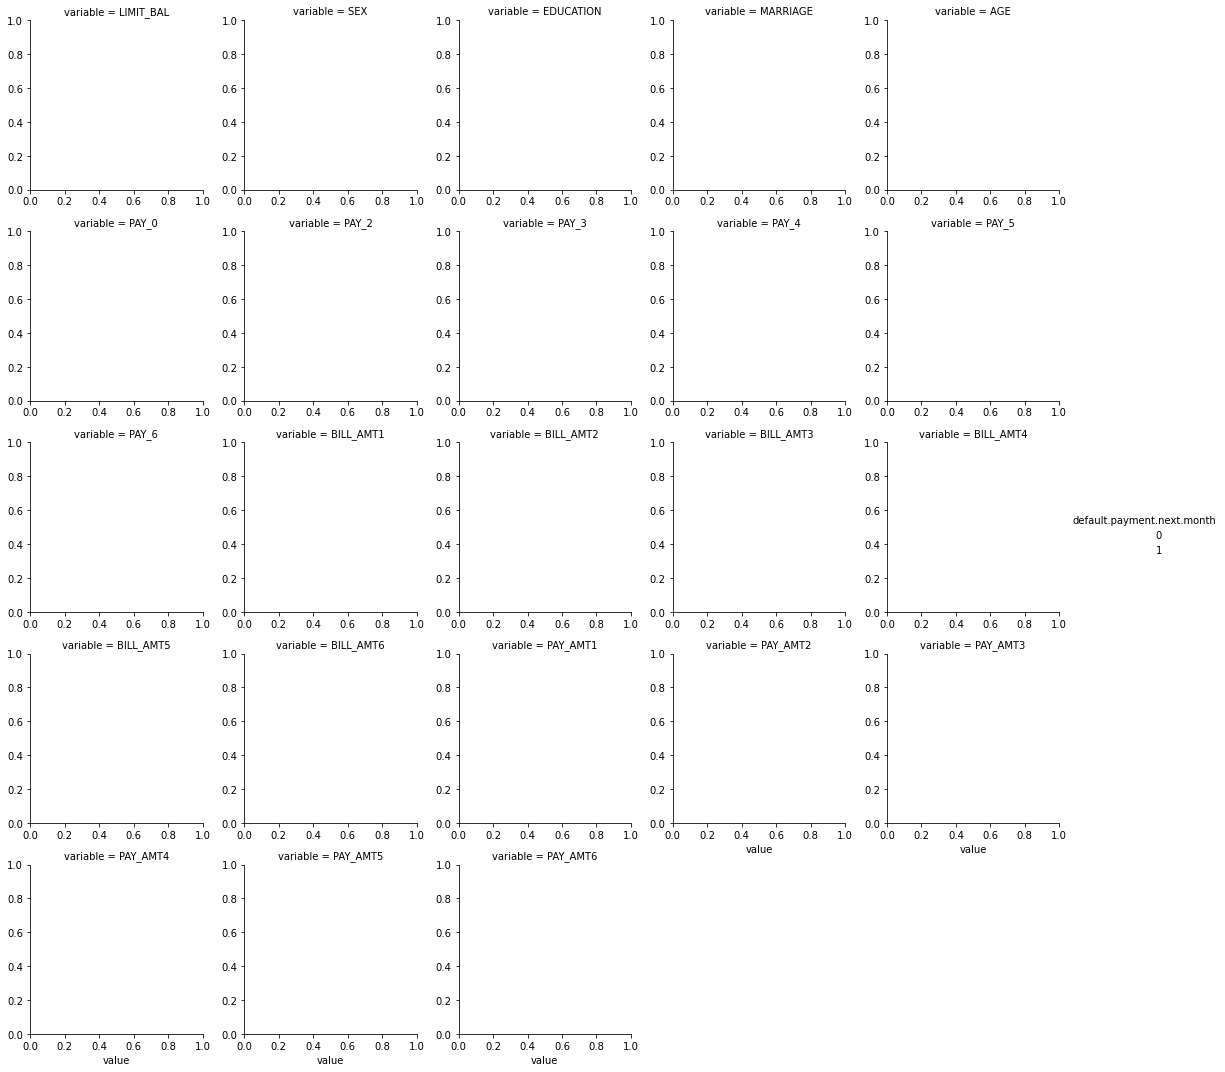

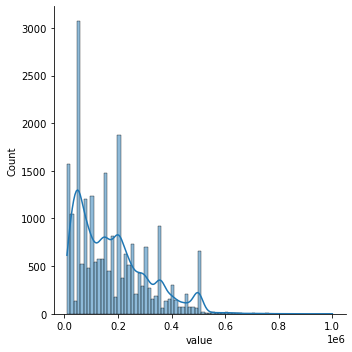

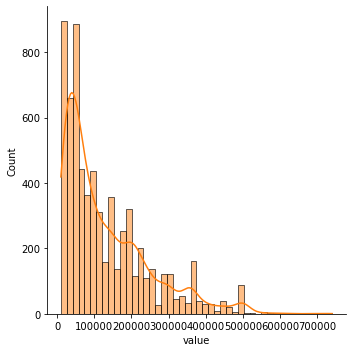

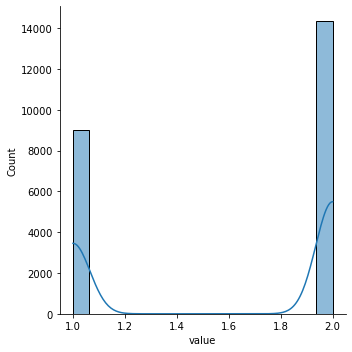

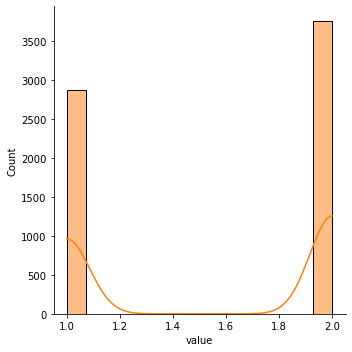

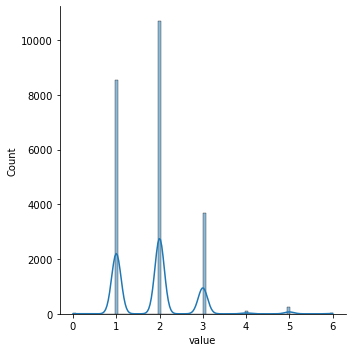

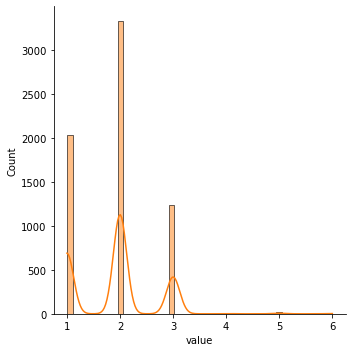

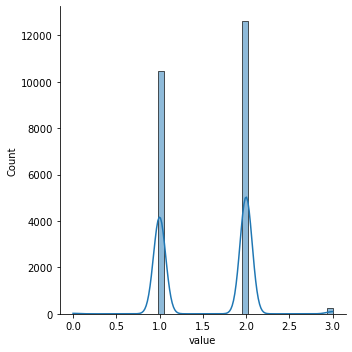

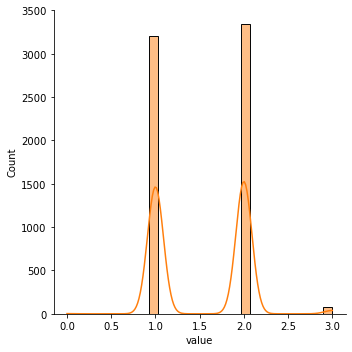

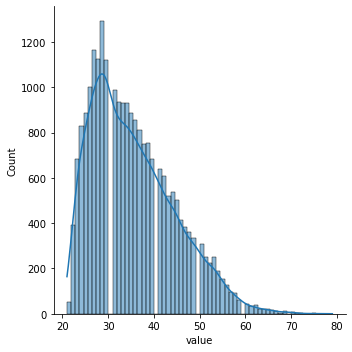

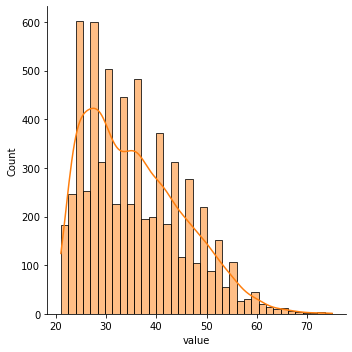

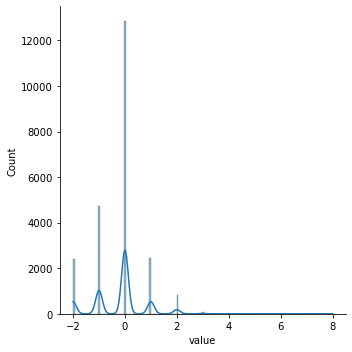

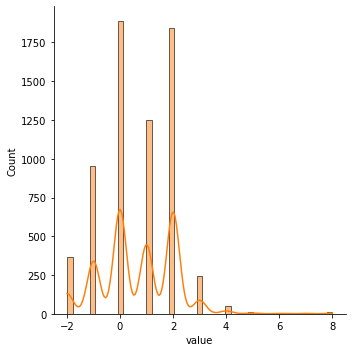

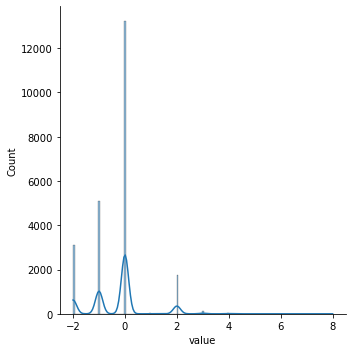

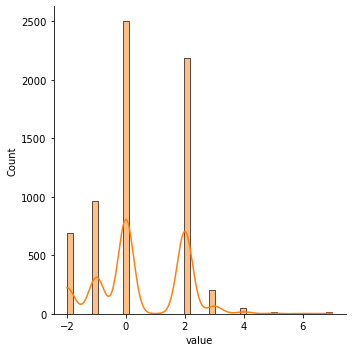

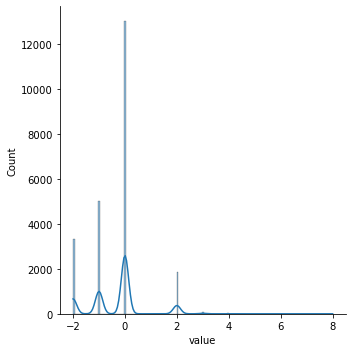

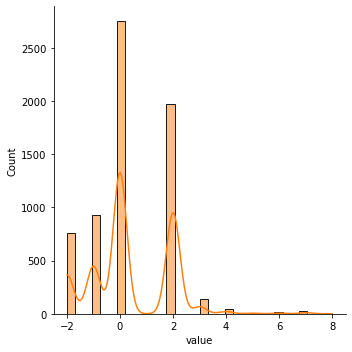

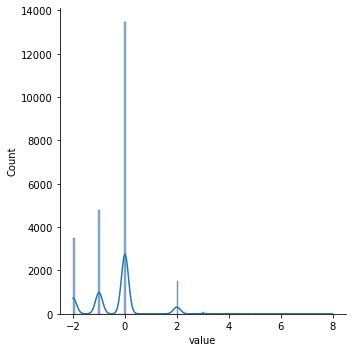

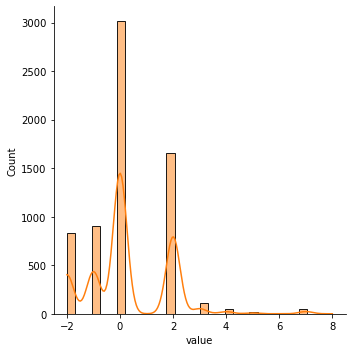

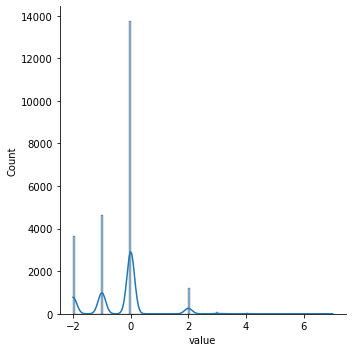

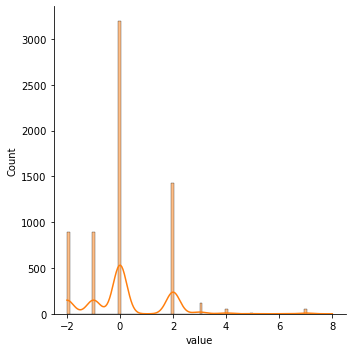

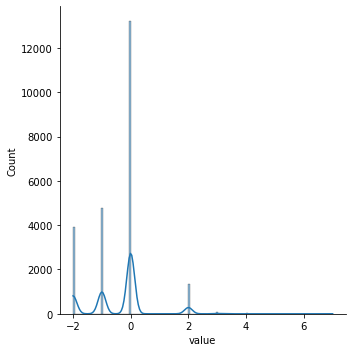

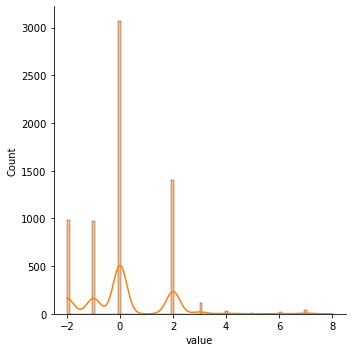

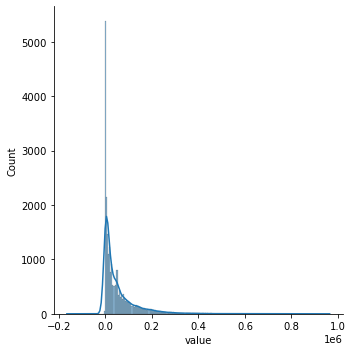

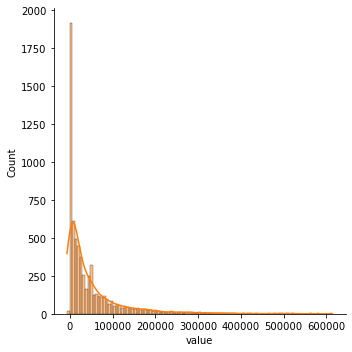

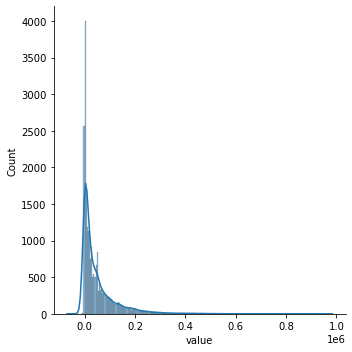

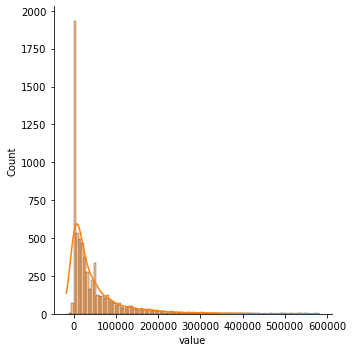

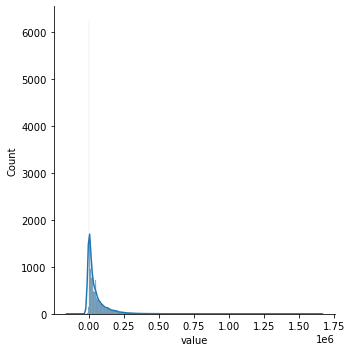

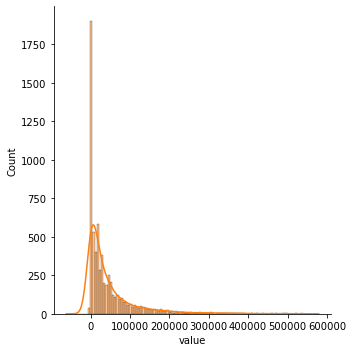

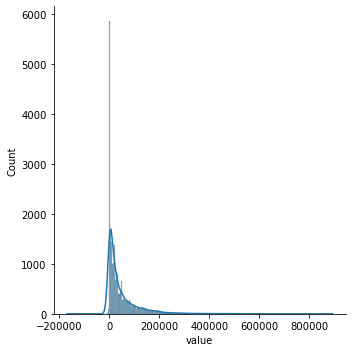

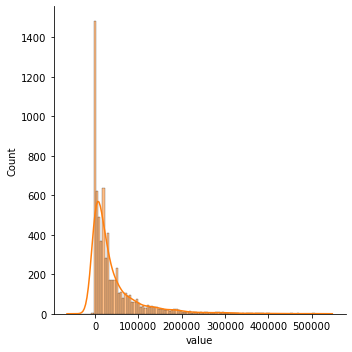

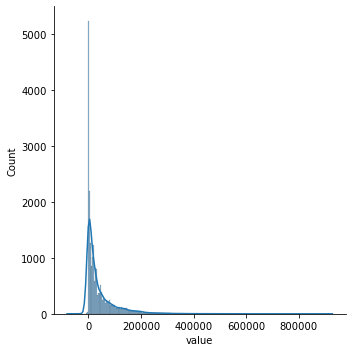

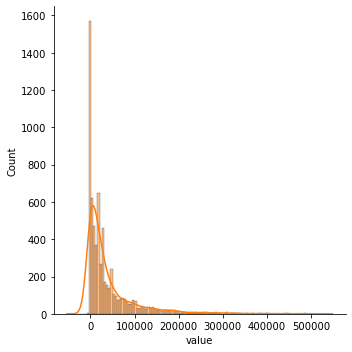

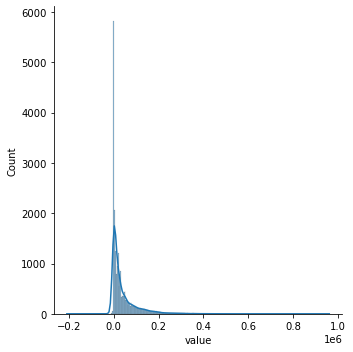

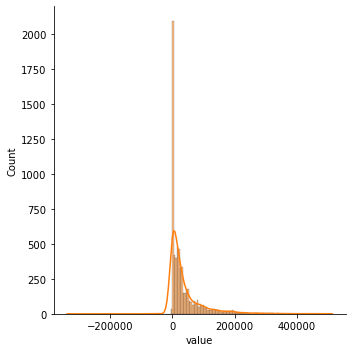

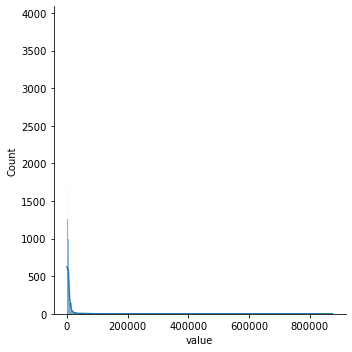

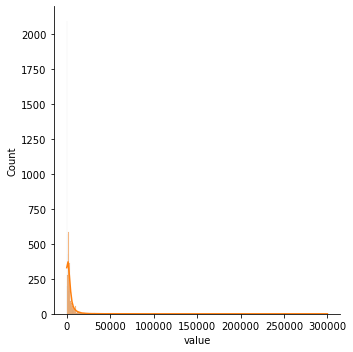

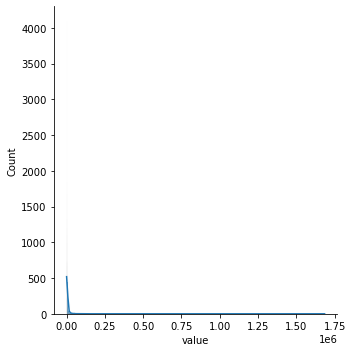

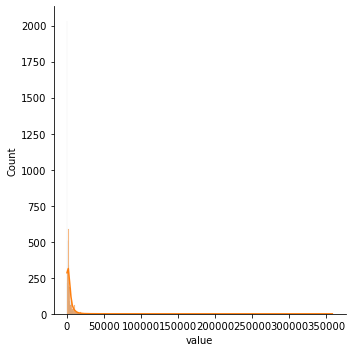

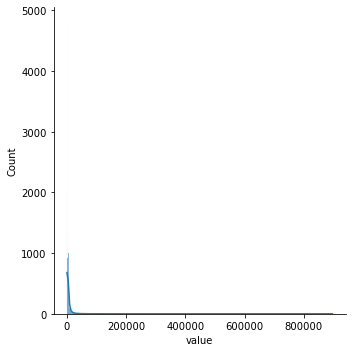

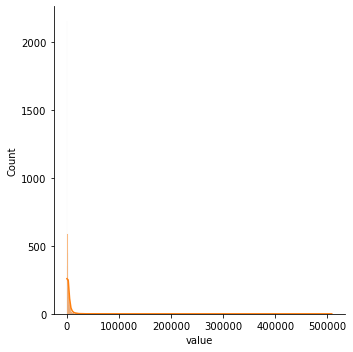

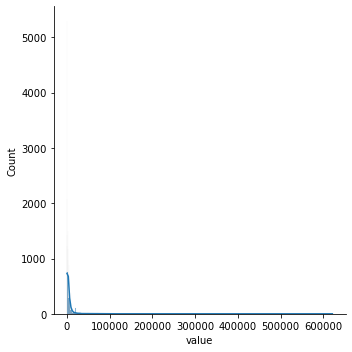

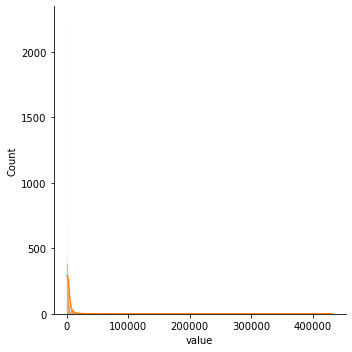

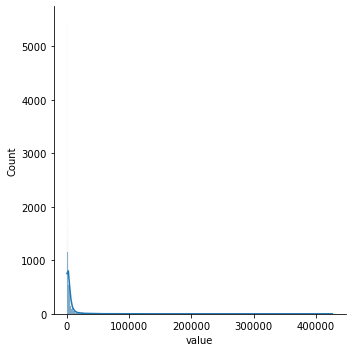

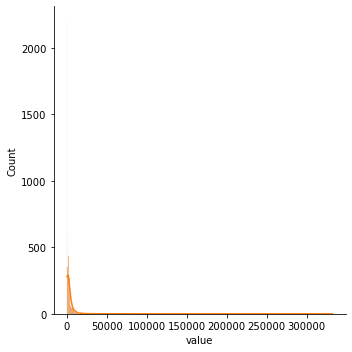

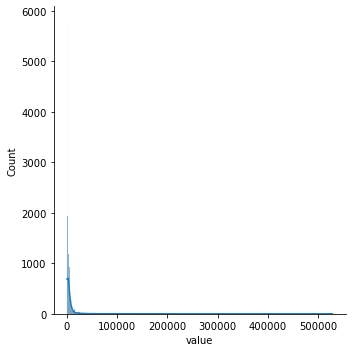

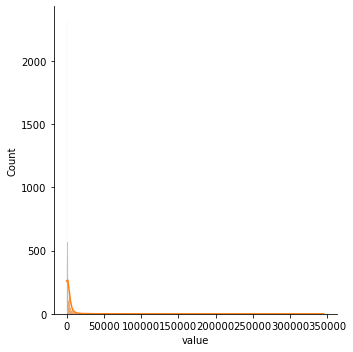

In [4]:
cols = [ f for f in data.columns if data.dtypes[ f ] != "object"]
cols.remove( "ID")
cols.remove( output )

f = pd.melt( data, id_vars=output, value_vars=cols)
g = sns.FacetGrid( f, hue=output, col="variable", col_wrap=5, sharex=False, sharey=False )
g = g.map( sns.displot, "value", kde=True).add_legend()

Observations:

Defaults have a higher proportion of Lower LIMIT_BAL values

NonDefaults have a higher proportion of Females (Sex=2)

NonDefaults have a higher proportion of MoreEducated (EDUCATION=1 or 2)

NonDefaults have a higher proportion of Singles (MARRIAGE=2)

NonDefaults have a higher proportion of people 30-40years

NonDefaults have a MUCH higher proportion of zero or negative PAY_X variables (this means that being current or ahead of payments is associated with not defaulting in the following month).
This is a strong relationship as the distribution are more separated - so we expect the PAY_X to be important!

(Clearly we're going to have to transform those dollar amounts in the PAY_AMTX and BILL_AMTX variables.)


How significant are these relationships? Given the observed data, is it possible we're imagining relationships when they're not really that strong?


In [4]:
def ChiSquaredTestOfIndependence( df, inputVar, Outcome_Category ):
    # Useful to have this wrapped in a function
    # The ChiSquaredTest of Independence - 
    # has a null hypothesis: the OutcomeCategory is independent of the inputVar
    # So we create a test-statistic which is a measure of the difference between 
    # "expected" i.e. what we WOULD observe if the OutcomeCategory WAS independent of the inputVar
    # "observed" i.e. what the data actually shows
    # the p-value returned is the probability of seeing this test-statistic if the null-hypothesis is true
    Outcome_Category_Table = df.groupby( Outcome_Category )[ Outcome_Category ].count().values
    Outcome_Category_Ratios = Outcome_Category_Table / sum( Outcome_Category_Table )
    possibleVals = df[inputVar].unique()
    observed = []
    expected = []
    for possible in possibleVals:
        countsInCategories = df[ df[ inputVar ] == possible ].groupby( Outcome_Category )[Outcome_Category].count().values
        if( len(countsInCategories) != len( Outcome_Category_Ratios ) ):
            print("Error! The class " + str( possible) +" of \'" + inputVar + "\' does not contain all values of \'" + Outcome_Category + "\'" )
            return
        elif( min(countsInCategories) < 5 ):
            print("Chi Squared Test needs at least 5 observations in each cell!")
            print( inputVar + "=" + str(possible) + " has insufficient data")
            print( countsInCategories )
            return
        else:
            observed.append( countsInCategories )   
            expected.append( Outcome_Category_Ratios * len( df[df[ inputVar ] == possible ]))
    observed = np.array( observed )
    expected = np.array( expected )
    chi_squared_stat = ((observed - expected)**2 / expected).sum().sum()
    degOfF = (observed.shape[0] - 1 ) *(observed.shape[1] - 1 ) 
    #crit = stats.chi2.ppf(q = 0.95,df = degOfF) 
    p_value = 1 - stats.chi2.cdf(x=chi_squared_stat, df=degOfF)
    print("Calculated test-statistic is %.2f" % chi_squared_stat )
    print("If " + Outcome_Category + " is indep of " + inputVar + ", this has prob %.2e of occurring" % p_value )
    #t_stat, p_val, doF, expArray = stats.chi2_contingency(observed= observed, correction=False)
    #print("Using built-in stats test: outputs")
    #print("test-statistic=%.2f, p-value=%.2f, degsOfFreedom=%d" % ( t_stat, p_val, doF ) )

In [5]:
ChiSquaredTestOfIndependence( data, "SEX", output )

Calculated test-statistic is 47.91
If default.payment.next.month is indep of SEX, this has prob 4.47e-12 of occurring


In [6]:
# Ok. So "default" is not independent of "SEX".
ChiSquaredTestOfIndependence( data, "EDUCATION", output )   

Error! The class 0 of 'EDUCATION' does not contain all values of 'default.payment.next.month'


In [7]:
print("We have %d with EDUCATION=0" % len(data.loc[ data["EDUCATION"]==0]))
print("We have %d with EDUCATION=4" % len(data.loc[ data["EDUCATION"]==4]))
print("We have %d with EDUCATION=5" % len(data.loc[ data["EDUCATION"]==5]))
print("We have %d with EDUCATION=6" % len(data.loc[ data["EDUCATION"]==6]))

We have 14 with EDUCATION=0
We have 123 with EDUCATION=4
We have 280 with EDUCATION=5
We have 51 with EDUCATION=6


In [8]:
# Since we have 30k samples, let's just put these non-typical Education instances all into the EDUCATION=4 class and continue 
data["EDUCATION_Corr"] = data["EDUCATION"].apply( lambda x: x if ((x>0) and (x<4)) else 4 )
ChiSquaredTestOfIndependence( data, "EDUCATION_Corr", output ) 
cols.remove("EDUCATION")
cols.append("EDUCATION_Corr")

ChiSquaredTestOfIndependence( data, "MARRIAGE", output ) 

Calculated test-statistic is 160.41
If default.payment.next.month is indep of EDUCATION_Corr, this has prob 0.00e+00 of occurring
Calculated test-statistic is 35.66
If default.payment.next.month is indep of MARRIAGE, this has prob 8.83e-08 of occurring


Ok. So default is not independent of EDUCATION_Corr nor independent of MARRIAGE.

I find it useful to separate the variables into "quantitative" vs "qualitative" and also to keep track of those that I've transformed (instead of overwriting them).

In [10]:
# The quantitative vars:
quant = ["LIMIT_BAL", "AGE"]

# The qualitative but "Encoded" variables (ie most of them)
qual_Enc = cols
qual_Enc.remove("LIMIT_BAL")
qual_Enc.remove("AGE")

And the PAY_ variables? We can see those are important, but we'll transform the BILL_AMT and PAY_AMT variables from NT Dollars to Log(NT Dollars)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

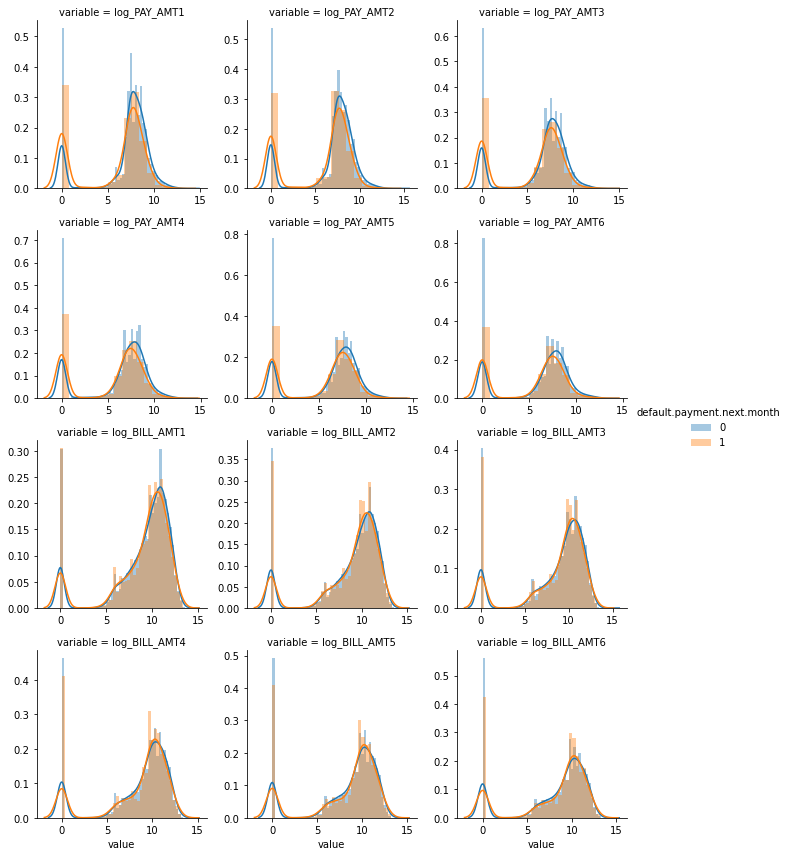

In [11]:
logged = []
for ii in range(1,7):
    qual_Enc.remove("PAY_AMT" + str( ii ))
    data[ "log_PAY_AMT" + str( ii )]  = data["PAY_AMT"  + str( ii )].apply( lambda x: np.log1p(x) if (x>0) else 0 )
    logged.append("log_PAY_AMT" + str( ii ) )

for ii in range(1,7):
    qual_Enc.remove("BILL_AMT" + str( ii ))
    data[ "log_BILL_AMT" + str( ii )] = data["BILL_AMT" + str( ii )].apply( lambda x: np.log1p(x) if (x>0) else 0 )
    logged.append("log_BILL_AMT" + str( ii ) )

f = pd.melt( data, id_vars=output, value_vars=logged)
g = sns.FacetGrid( f, hue=output, col="variable", col_wrap=3, sharex=False, sharey=False )
g = g.map( sns.distplot, "value", kde=True).add_legend()

It looks like higher Log PAY_AMT is associated with slightly less default.

So now we have quant variables, qual_Enc variables and logged variables. Let's check correlations with the output variable:

<AxesSubplot:>

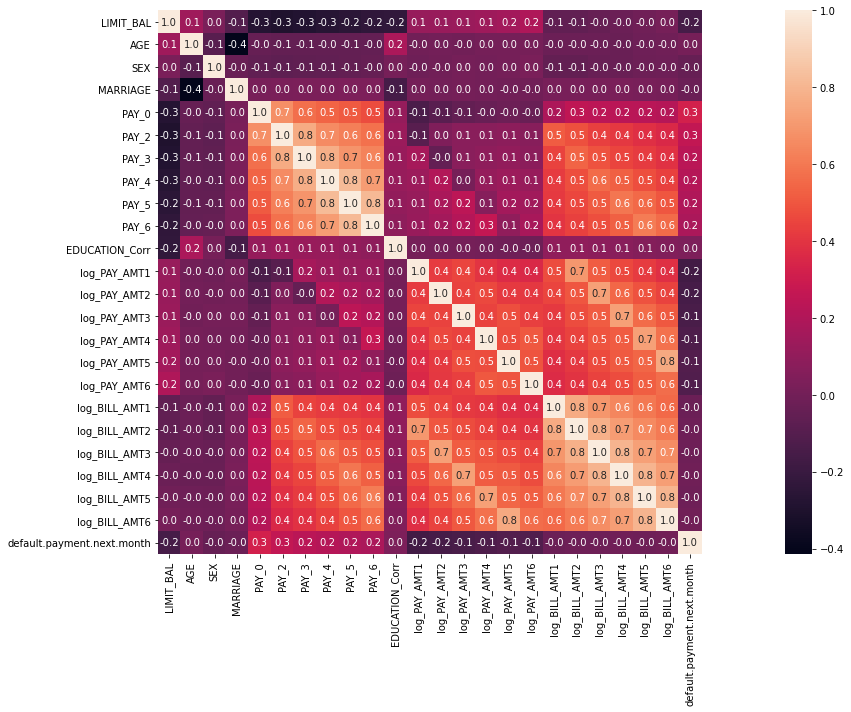

In [12]:
features = quant + qual_Enc + logged + [output]
corr = data[features].corr()
plt.subplots(figsize=(30,10))
sns.heatmap( corr, square=True, annot=True, fmt=".1f" )  

So it looks like the PAY_0, PAY_X variables are the strongest predictors of default, followed by the LIMIT_BAL and Log_PAY_AMT variables.

To make predictions about whether a customer is likely to default - we'll train a number of different classifiers and see how well they perform. As usual, we start by splitting the data into train/test sets and rescaling.

In [13]:
features = quant + qual_Enc + logged   
X = data[features].values    
y = data[ output ].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2)

from sklearn.preprocessing import StandardScaler
scX = StandardScaler()
X_train = scX.fit_transform( X_train )
X_test = scX.transform( X_test )

# We'll need some metrics to evaluate our models
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

We don't expect the data to be linearly separable - so we'll start with the RandomForest classifier and kernel-SVM

In [14]:
#-------------- 
# Random Forest 
#--------------
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=10)
classifier.fit( X_train, y_train )
y_pred = classifier.predict( X_test )

cm = confusion_matrix( y_test, y_pred )
print("Accuracy on Test Set for RandomForest = %.2f" % ((cm[0,0] + cm[1,1] )/len(X_test)))
scoresRF = cross_val_score( classifier, X_train, y_train, cv=10)
print("Mean RandomForest CrossVal Accuracy on Train Set %.2f, with std=%.2f" % (scoresRF.mean(), scoresRF.std() ))

#-------------- 
# kernel SVM 
#--------------
from sklearn.svm import SVC
classifier1 = SVC(kernel="rbf")
classifier1.fit( X_train, y_train )
y_pred = classifier1.predict( X_test )

cm = confusion_matrix( y_test, y_pred )
print("Accuracy on Test Set for kernel-SVM = %.2f" % ((cm[0,0] + cm[1,1] )/len(X_test)))
scoresSVC = cross_val_score( classifier1, X_train, y_train, cv=10)
print("Mean kernel-SVM CrossVal Accuracy on Train Set %.2f, with std=%.2f" % (scoresSVC.mean(), scoresSVC.std() ))

Accuracy on Test Set for RandomForest = 0.81
Mean RandomForest CrossVal Accuracy on Train Set 0.80, with std=0.00
Accuracy on Test Set for kernel-SVM = 0.82
Mean kernel-SVM CrossVal Accuracy on Train Set 0.82, with std=0.00


We'll check some of the other classifiers - but we don't expect they will do better

In [15]:
#-------------- 
# Logistic Regression 
#--------------
from sklearn.linear_model import LogisticRegression
classifier2 = LogisticRegression()
classifier2.fit( X_train, y_train )
y_pred = classifier2.predict( X_test )

cm = confusion_matrix( y_test, y_pred )
print("Accuracy on Test Set for LogReg = %.2f" % ((cm[0,0] + cm[1,1] )/len(X_test)))
scoresLR = cross_val_score( classifier2, X_train, y_train, cv=10)
print("Mean LogReg CrossVal Accuracy on Train Set %.2f, with std=%.2f" % (scoresLR.mean(), scoresLR.std() ))

#-------------- 
# Naive Bayes 
#--------------
from sklearn.naive_bayes import GaussianNB
classifier3 = GaussianNB()
classifier3.fit( X_train, y_train )
y_pred = classifier3.predict( X_test )
cm = confusion_matrix( y_test, y_pred )
print("Accuracy on Test Set for NBClassifier = %.2f" % ((cm[0,0] + cm[1,1] )/len(X_test)))
scoresNB = cross_val_score( classifier3, X_train, y_train, cv=10)
print("Mean NaiveBayes CrossVal Accuracy on Train Set %.2f, with std=%.2f" % (scoresNB.mean(), scoresNB.std() ))

#-------------- 
# K-NEIGHBOURS 
#--------------
from sklearn.neighbors import KNeighborsClassifier
classifier4 = KNeighborsClassifier(n_neighbors=5)
classifier4.fit( X_train, y_train )
y_pred = classifier4.predict( X_test )
cm = confusion_matrix( y_test, y_pred )
print("Accuracy on Test Set for KNeighborsClassifier = %.2f" % ((cm[0,0] + cm[1,1] )/len(X_test)))
scoresKN = cross_val_score( classifier3, X_train, y_train, cv=10)
print("Mean KN CrossVal Accuracy on Train Set Set %.2f, with std=%.2f" % (scoresKN.mean(), scoresKN.std() ))

Accuracy on Test Set for LogReg = 0.81
Mean LogReg CrossVal Accuracy on Train Set 0.81, with std=0.00
Accuracy on Test Set for NBClassifier = 0.76
Mean NaiveBayes CrossVal Accuracy on Train Set 0.76, with std=0.01
Accuracy on Test Set for KNeighborsClassifier = 0.79
Mean KN CrossVal Accuracy on Train Set Set 0.76, with std=0.01


Conclusion: Using a kernel-SVM classifier, we can predict with ~82% accuracy, whether a customer is likely to default next month.

The strongest predictors of default are the PAY_X (ie the repayment status in previous months), the LIMIT_BAL & the PAY_AMTX (amount paid in previous months).

Demographics: we see that being Female, More educated, Single and between 30-40years old means a customer is more likely to make payments on time.